# Results R1b: What sentiments, topics and social metrics are present in the letter chunks?

## Accounting for authors

### Resources

In [15]:
# Get Packages & Libraries
library(tidyverse)
library(brms)
library(ggridges)
library(rethinking)
library(patchwork)

In [9]:
# Functions
factorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "character")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

st <- function(x){
    (x-mean(x,na.rm=TRUE))/sd(x,na.rm=TRUE)
}

In [10]:
# Settings
options(scipen=999)

In [11]:
# Get Data
df  <- read.csv("20250318_PhD_LtrChk-RQ1a.csv")
#df[df == ''] <- NA #replace blank cells with NA
df <- factorize(df)
glimpse(df)

Rows: 2,392
Columns: 42
$ docID.AT         <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ docid            <fct> 20910, 21062, 21062, 21324, 21334, 21334, 21354, 2135…
$ docyear          <int> 1891, 1871, 1871, 1892, 1891, 1891, 1890, 1890, 1800,…
$ docmonth         <int> 7, 11, 11, 5, 10, 10, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1…
$ authorName       <fct> Isabella Weir Moore, E. Rothwell, E. Rothwell, Isabel…
$ docauthorid      <fct> IED0107, IED0179, IED0179, IED0107, IED0621, IED0621,…
$ authorLocation   <fct> USA, Canada, Canada, USA, USA, USA, USA, USA, USA, US…
$ authorGender     <fct> F, F, F, F, F, F, M, M, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> Irish, Irish, Irish, Irish, Irish, Irish, Irish, Iris…
$ irish            <fct> True, True, True, True, True, True, True, True, True,…
$ otherUK          <fct> False, False, False, False, False, False, False, Fals…
$ relMin           <fct> NA, NA, NA, NA, False, False, NA, NA, NA, NA, NA, NA,…
$ catholic      

In [6]:
df$authorName <- as.character(df$authorName)
df$authorName[is.na(df$authorName)] <- "Unknown"
df$authorName <- as.factor(df$authorName)
#summary(df$authorName)
sum(is.na(df$authorName))

[1] 0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    2.00    4.00   13.75    9.00  460.00 

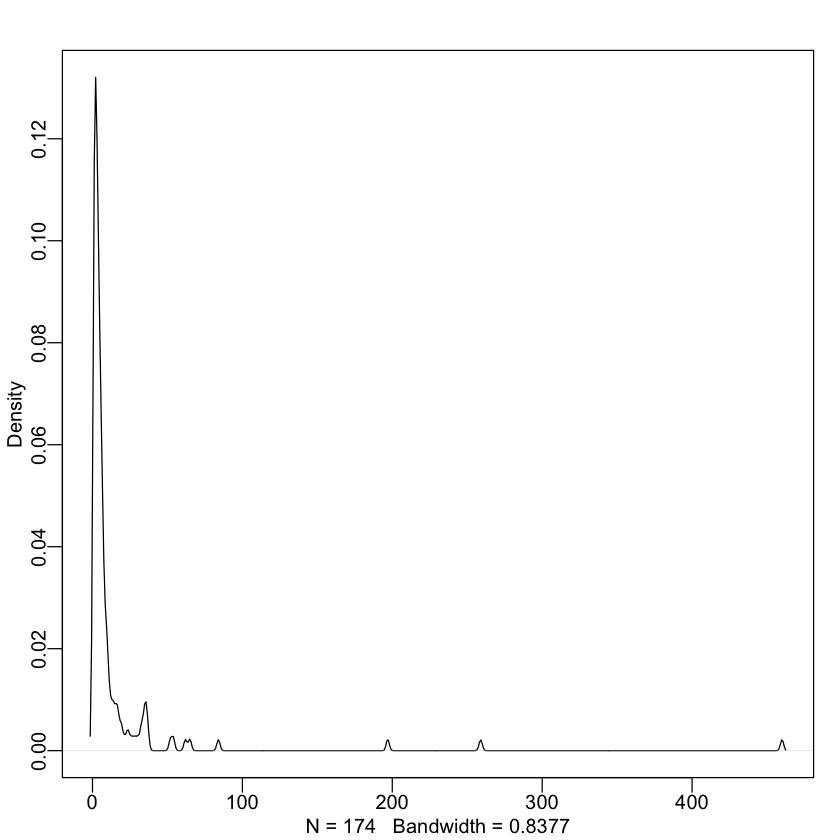

In [7]:
counts <- df %>% 
group_by(docauthorid) %>% 
count() %>%
arrange(desc(n)) %>% 
pull(n)

dens(counts)
summary(counts)


In [8]:
set.seed(1)

counts <- df %>% 
group_by(docauthorid) %>% 
count() %>%
arrange(desc(n))

# High representation
idsHigh <- counts %>% 
filter (n >= 10) %>%
pull(docauthorid) %>% 
sample(3) %>% 
sort()
namesHigh <- df %>% filter(docauthorid %in% idsHigh) %>% select(authorName, docauthorid) %>% unique() %>% arrange(docauthorid) %>% pull(authorName)
repHigh <- namesHigh %>% data.frame() %>% rename(name = ".") %>% mutate(docauthorid = idsHigh) %>% mutate(group = "high")
    
# Average representation (better phrased as medium representation)
idsAve <- counts %>% 
filter (n >= 3 & n<=9) %>%
pull(docauthorid) %>% 
sample(3) %>% 
sort()
namesAve <- df %>% filter(docauthorid %in% idsAve) %>% select(authorName, docauthorid) %>% unique() %>% arrange(docauthorid) %>% pull(authorName)
repMed <- namesAve %>% data.frame() %>% rename(name = ".") %>% mutate(docauthorid = idsAve) %>% mutate(group = "medium")

# Low representation
idsLow <- counts %>% 
filter (n >= 1 & n<=2) %>%
pull(docauthorid) %>%
sample(3) %>% 
sort()
namesLow <- df %>% filter(docauthorid %in% idsLow) %>% select(authorName, docauthorid) %>% unique() %>% arrange(docauthorid) %>% pull(authorName)
repLow <- namesLow %>% data.frame() %>% rename(name = ".") %>% mutate(docauthorid = idsLow) %>% mutate(group = "low")

sample <- rbind(repHigh, repMed, repLow) %>% arrange(docauthorid)
sample

df%>%filter(docauthorid %in% sample$docauthorid)%>%distinct(authorName, docauthorid) %>% arrange(docauthorid)

name,docauthorid,group
<fct>,<fct>,<chr>
Catharine Bradley,IED0129,medium
Elizabeth Flemming,IED0208,low
George McCann,IED0233,high
Isabella Marshall Allen,IED0314,high
Matilda Lindsay,IED0678,medium
Susannah Strickland Moodie,per0004772,high
Unknown,per0025578,medium
J. C. Buchanan,per0029173,low
David Shone Harry,per0031175,low


authorName,docauthorid
<fct>,<fct>
Catharine Bradley,IED0129
Elizabeth Flemming,IED0208
George McCann,IED0233
Isabella Marshall Allen,IED0314
Matilda Lindsay,IED0678
Susannah Strickland Moodie,per0004772
Unknown,per0025578
J. C. Buchanan,per0029173
David Shone Harry,per0031175


### Complete pooling

$$CompoundSentiment_i \sim \mathrm{Normal}(\mu_i, \sigma)$$ 
$$\mu_i = \alpha $$
$$\alpha \sim \mathrm{Normal}(0,.2)$$
$$\sigma \sim \mathrm{Uniform}(0,.3)$$

https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf

In [9]:
# Complete Pooling - Rethinking
f1cp <- readRDS("20250318_PhD_LtrChkScoCom-cp.rds") # Get it back
precis(f1cp, prob = .90)

,mean,sd,5%,95%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,0.1424183,0.005937627,0.1326518,0.1521849
sigma,0.2905259,0.004200163,0.2836173,0.2974346


In [12]:
# Now swtiching to the more efficient BRMS package.
# What priors are needed?
#get_prior(data=df, family=gaussian, formula=scoreCom ~ 1)

#f2cp <- brm(data=df,
#           family=gaussian,
#           scoreCom ~ 1,
#           prior=c(prior("normal(0,.2)",class=Intercept), # alpha, intercept, average score for all students
#                   prior("uniform(0,.3)",class="sigma", ub=.3)), # sigma, global standard deviation
#          iter=2000,warmup = 1000,chains=4,cores=4, seed = 4,
#          file = "20250319_PhD_LtrChkScoCom-cp")

f2cp <- readRDS("20250319_PhD_LtrChkScoCom-cp.rds")
print(f2cp, probs = c(.05, .95))
#prior_summary(f2cp)

#posterior_summary(f2cp)[1:2,]

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 
   Data: df (Number of observations: 2392) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.14      0.01     0.13     0.15 1.00     2420     2383

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.29      0.00     0.28     0.30 1.00     1497      996

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).


In [11]:
set.seed(5)

nd <- distinct(df, docauthorid)

f <- data.frame(predict(f2cp,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

f <- f %>%                                   
  gather(variable, value)

summary(f$value)
#dens(f$value)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.23337 -0.05491  0.14157  0.14180  0.33842  1.49101 

### No pooling

In [12]:
df$docauthorid %>% unique() %>% length()

[1] 174

<p>There are 174 docauthorids -- too many to include each one as a dummy variable. A similar approach can be achieved by using a fixed effects model with an index variable, as described <a href="https://bookdown.org/content/4857/the-many-variables-the-spurious-waffles.html#many-categories">here</a> (section 5.3.2, model b5.9) and <a href="https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf">here</a> (slide 10). Each group gets its own independent intercept (i.e., no global mean). Kurz calls this the <a href="https://bookdown.org/content/4857/models-with-memory.html">"no pooling (i.e., the single-level αtank[i] model)"</a> approach.</p>

$$CompoundSentiment_{i} \sim Normal(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha_{docauthorid[i]}$$
$$\alpha_j \sim Normal(0, .2) \quad for \quad j = 1,…,174$$ 
$$\sigma \sim Uniform(0,.3)$$


McMahan specifies the no-pooling (fixed effects) approach as follows:

$$CompoundSentiment_{ik} \sim Normal(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$ 
$$\alpha_k \sim Normal(0,.2)$$ 
$$\sigma \sim Uniform(0,.3)$$ 

<ul>
<li>See specification b5.9 in Kurz (2023, Version 0.4.0).</li>
    <li>soci620_18_nestedDataPartialPooling.pdf</li>
    <li>McElreath(2020, Section 13.2.4. and p. 414)</li>
</ul>

In [13]:
#get_prior(data=df2, family=gaussian, valence ~ 0 + docauthorid)

f4npI <- readRDS("20250319_PhD_LtrChkScoCom-npI.rds")

# No pooling index / fixed effects approach
#f4npI <- brm(data=df,
#            family = 'gaussian',
#           formula= scoreCom ~ 0 + docauthorid, # **
#            prior=c(set_prior("normal(0,.2)",class="b"),
#                   set_prior("uniform(0,.3)",class="sigma", ub = .3)),
#           iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#           file = "20250319_PhD_LtrChkScoCom-npI.rds",
#            control=list(adapt_delta=.99))
#print(f4npI)
#idsB <- paste("b_docauthorid", ids, sep = "")
posterior_summary(f4npI, probs = c(.05, .95))[1:10,]
#prior_summary(f4npI)
# See Kurz (2023, version 0.4.0, Section 13.2.4 and Model b5.8) for specification 
## This can also be achieved using -1 + notation described in https://soci620.netlify.app/labs/lab_17.Rmd
### See pg 14
#### See also b13.1

,Estimate,Est.Error,Q5,Q95
b_docauthoridIED0028,0.07273350,0.14105393,-0.157189916,0.3076217
b_docauthoridIED0030,0.09935222,0.05248087,0.014342381,0.1859534
b_docauthoridIED0032,0.47012458,0.14142979,0.233952614,0.7067330
b_docauthoridIED0037,0.06125835,0.03295666,0.007266908,0.1167894
b_docauthoridIED0068,0.31568604,0.11311688,0.129253941,0.5026659
b_docauthoridIED0069,0.39567404,0.13858465,0.165469162,0.6286634
b_docauthoridIED0070,0.34458321,0.09686604,0.185376244,0.5009103
b_docauthoridIED0072,0.41385414,0.13969757,0.180438992,0.6487423
b_docauthoridIED0075,0.04973177,0.11444104,-0.138173224,0.2362367
b_docauthoridIED0078,0.17416198,0.10560376,-0.005151716,0.3460526


In [17]:
set.seed(5)

nd <- distinct(df, docauthorid)

p <- data.frame(predict(f4npI,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

p <- p %>%                                   
  gather(variable, value)

summary(p$value)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.41581 -0.09919  0.11638  0.11769  0.33376  1.68264 

In [18]:
posteriorCheck <- p %>% pull(value)
summary(posteriorCheck)
sum(posteriorCheck > 1)
sum(posteriorCheck < -1)
length(posteriorCheck)           
round((sum(posteriorCheck > 1) / length(posteriorCheck)) + (sum(posteriorCheck < -1) / length(posteriorCheck)), digits = 3)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.41581 -0.09919  0.11638  0.11769  0.33376  1.68264 

[1] 2536

[1] 232

[1] 696000

[1] 0.004

In [19]:
set.seed(5)

nd <- distinct(df, docauthorid)

f <- data.frame(fitted(f4npI,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

summary(f$Estimate)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.32840  0.03877  0.09654  0.11831  0.18495  0.60370 

In [20]:
#What are the author means from the original dataset?
authorMeans <- df %>% 
select(docauthorid, scoreCom) %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
pull(mean)
summary(authorMeans)
#dens(authorMeans)
#sd(authorMeans)

#How many segments below the lowest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean < -0.32840) %>%
nrow()

#How many segments above the highest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean > 0.60370) %>%
nrow()

14/174

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9200  0.0600  0.1400  0.1769  0.2800  0.9700 

[1] 3

[1] 11

[1] 0.08045977

### Partial Pooling

<p>The other way to model clusters is with "partial pooling" (random effects)</p>

$$CompoundSentiment_{ik} \sim \mathrm{Normal}(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$
$$\alpha_k \sim \mathrm{Normal}(\gamma, \phi) $$ 
$$\gamma \sim \mathrm{Normal}(0,.2) $$ 
$$\phi \sim \mathrm{Uniform}(0,.3) $$
$$\sigma \sim \mathrm{Uniform}(0,.3)$$ 

<ul>
    <li>* Typical writer (fixed)</li>
    <li>** Variability for each writer (random).</li>
</ul>

<p>For general notation, see https://soci620.netlify.app/slides/soci620_19_randomIntercepts.pdf and https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf (slide 11), noting that $\phi$ and $\eta$ are used in the different examples to represent sd (variability between all classrooms). I used $\phi$ here.

In [14]:
#get_prior(data=df, family=gaussian, scoreCom ~ 1 + (1 | docauthorid))

f5pp <- readRDS("20250319_PhD_LtrChkScoCom-pp.rds")

#f5pp <- brm(data=df,
#            family = 'gaussian',
#            formula = scoreCom ~ 1 + (1 | docauthorid),
#            prior=c(set_prior("normal(0,.2)",class="Intercept"), # gamma
#                    set_prior("uniform(0,.3)",class="sd", ub=.3), #phi
#                    set_prior("uniform(0,.3)",class="sigma", ub=.3)), #sigma
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20250319_PhD_LtrChkScoCom-pp",
#           control=list(adapt_delta=.99))
print(f5pp)

#posterior_summary(f5pp, probs = c(.05, .95))[1,] %>% round(digits = 2)
#prior_summary(f5pp)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + (1 | docauthorid) 
   Data: df (Number of observations: 2392) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 174) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.14      0.01     0.11     0.17 1.00     1271     2132

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.17      0.01     0.14     0.20 1.00     1751     2379

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.27      0.00     0.26     0.28 1.00     5027     2323

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at converg

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.29276 -0.03487  0.16933  0.17056  0.37406  1.61941 

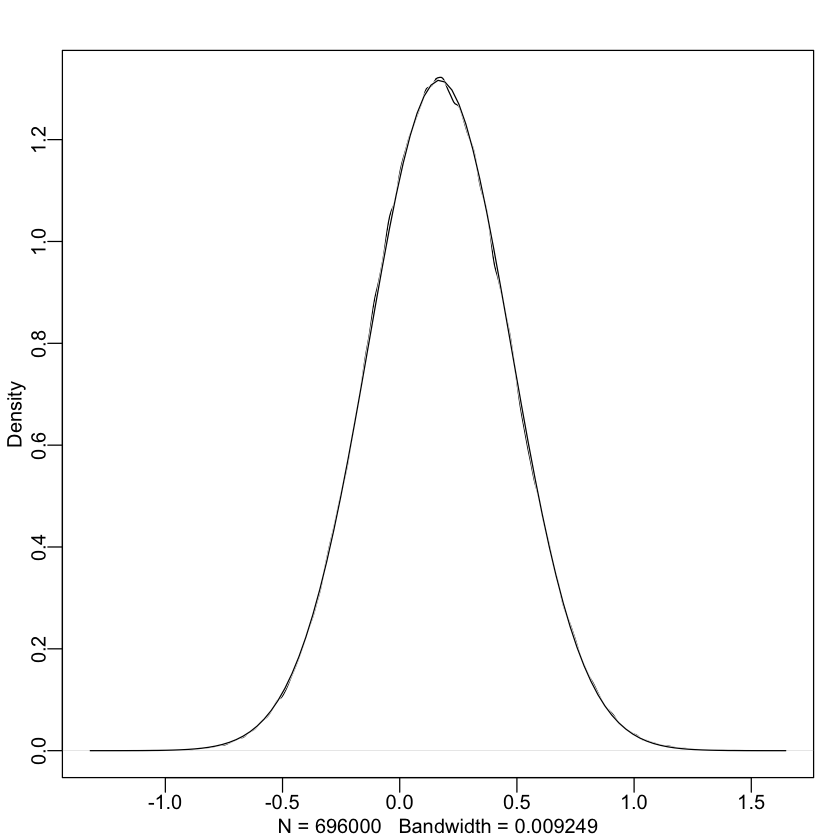

In [22]:
set.seed(5)

nd <- distinct(df, docauthorid)

p <- data.frame(predict(f5pp,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

p <- p %>%                                   
  gather(variable, value)

summary(p$value)
dens(p$value, norm.comp = TRUE)

In [23]:
posteriorCheck <- p %>% pull(value)
summary(posteriorCheck)
sum(posteriorCheck > 1)
sum(posteriorCheck < -1)
length(posteriorCheck)           
round((sum(posteriorCheck > 1) / length(posteriorCheck)) + (sum(posteriorCheck < -1) / length(posteriorCheck)), digits = 3)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.29276 -0.03487  0.16933  0.17056  0.37406  1.61941 

[1] 2339

[1] 32

[1] 696000

[1] 0.003

In [24]:
set.seed(5)

nd <- distinct(df, docauthorid)

f <- data.frame(fitted(f5pp,
         newdata = nd,
         probs = c(.05, .95), 
         summary = T))

#summary(f$Estimate)
#dens(f$Estimate, norm.comp = TRUE)


Saving 7 x 7 in image


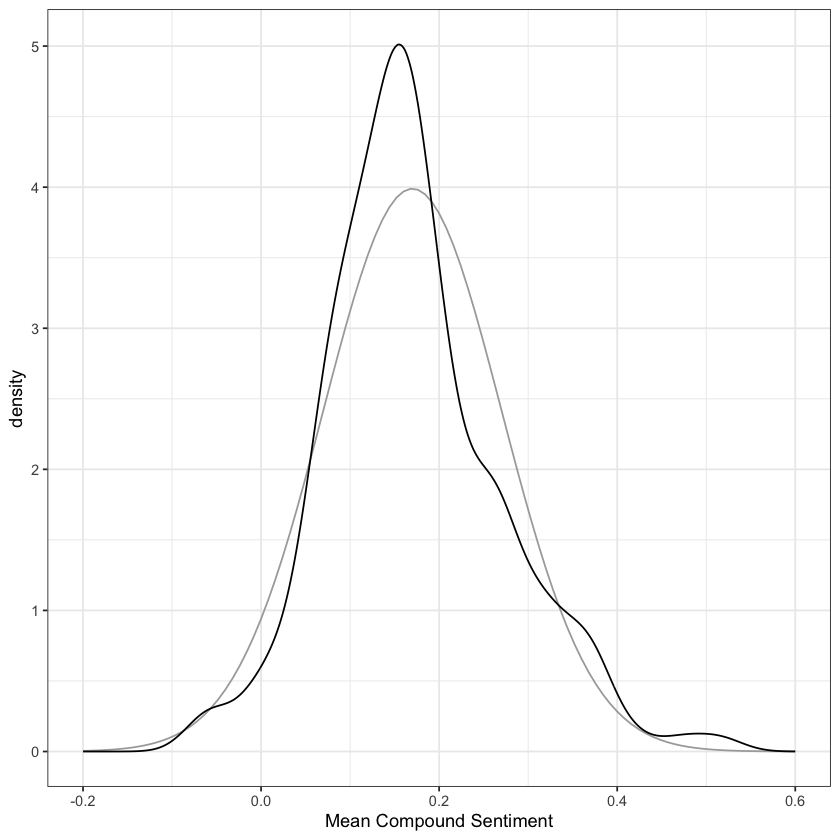

In [25]:
p <- f %>% ggplot(aes(x = Estimate)) + 
   xlim(-.2, .6) + 
   stat_function(fun = dnorm, args = list(mean = .17, sd = .1), colour = "darkgrey") + 
geom_density()+
xlab("Mean Compound Sentiment")+
theme_bw()

p

ggsave("20250313_PhD_CsPp-RandomMeansAll.jpg")

In [26]:
#What are the author means from the original dataset?
authorMeans <- df %>% 
select(docauthorid, scoreCom) %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
pull(mean)
summary(authorMeans)
#dens(authorMeans)
#sd(authorMeans)

#How many segments below the lowest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean < -0.06615) %>%
nrow()

#How many segments above the highest modeled?
df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2))%>%
filter(mean > 0.51591) %>%
nrow()

29/174

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.9200  0.0600  0.1400  0.1769  0.2800  0.9700 

[1] 16

[1] 13

[1] 0.1666667

In [27]:
# Means -- Most

#nd <- distinct(df, docauthorid)
nd = idsHigh %>% data.frame() %>% rename(docauthorid = 1)

f <- data.frame(fitted(f5pp,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

#colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")
#colnames(f) <- df %>% filter(docauthorid %in% idsMost) %>% select(authorName, docauthorid) %>% unique() %>% arrange(docauthorid) %>% pull(authorName)
colnames(f) <- namesHigh

f <- f %>%                                   
  gather(variable, value)

p1 <- ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
coord_cartesian(xlim = c(-1, 1))+
  theme(legend.position = "none", axis.text.x=element_blank()) + 
xlab("10 or more segments") +
ylab("")

In [28]:
#Means - Average

nd = idsAve %>% data.frame() %>% rename(docauthorid = 1)

f <- data.frame(fitted(f5pp,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

#colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")
#colnames(f) <- df %>% filter(docauthorid %in% idsLeast) %>% select(authorName, docauthorid) %>% unique() %>% arrange(docauthorid) %>% pull(authorName)
colnames(f) <- namesAve

f <- f %>%                                   
  gather(variable, value)

p2 <- ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none", axis.text.x=element_blank()) + 
xlab("3 to 9 segments") +
ylab("") + 
coord_cartesian(xlim = c(-1, 1))

In [29]:
#Means - Least

nd = idsLow %>% data.frame() %>% rename(docauthorid = 1)

f <- data.frame(fitted(f5pp,
         newdata = nd,
         probs = c(.05, .95), 
         summary = F))

#colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")
#colnames(f) <- df %>% filter(docauthorid %in% idsLeast) %>% select(authorName, docauthorid) %>% unique() %>% arrange(docauthorid) %>% pull(authorName)
colnames(f) <- namesLow

f <- f %>%                                   
  gather(variable, value)

p3 <- ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() +
  theme(legend.position = "none") + 
xlab("1 to 2 segments") +
ylab("") + 
coord_cartesian(xlim = c(-1, 1))

Picking joint bandwidth of 0.00644

Picking joint bandwidth of 0.0152

Picking joint bandwidth of 0.0211

Saving 7 x 7 in image
Picking joint bandwidth of 0.00644

Picking joint bandwidth of 0.0152

Picking joint bandwidth of 0.0211



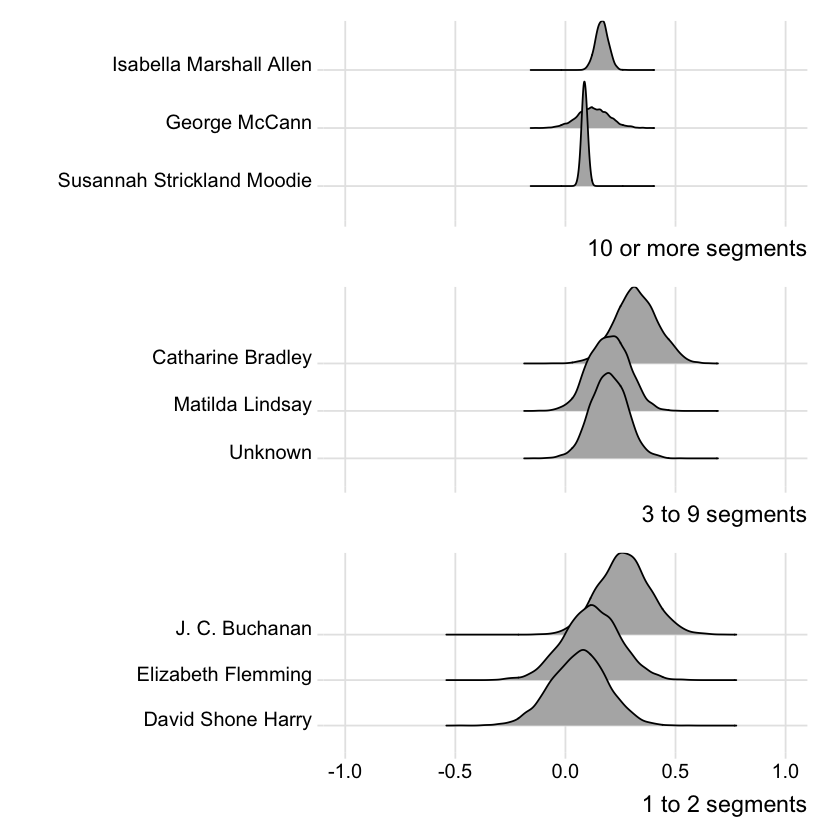

In [30]:
p <- p1 / p2 / p3
p
ggsave("20250313_PhD_CsPp-RandomMeans.jpg")

In [31]:
# Random + Fixed Estimates

# Way 1
post_mdn <- 
  coef(f5pp, probs = c(.05, .95))$docauthorid[, , ] %>% 
  data.frame() %>% rownames_to_column(var = "docauthorid") %>% 
arrange(docauthorid)

higEstimates <- post_mdn[post_mdn$docauthorid %in% idsHigh, ] 
aveEstimates <- post_mdn[post_mdn$docauthorid %in% idsAve, ] 
lowEstimates <- post_mdn[post_mdn$docauthorid %in% idsLow, ]

higEstimates %>%
mutate(authorName = namesHigh) %>%
select(authorName, Estimate, Est.Error, Q5, Q95)%>%
arrange(desc(Estimate))

aveEstimates %>%
mutate(authorName = namesAve) %>%
select(authorName, Estimate, Est.Error, Q5, Q95)%>%
arrange(desc(Estimate))

lowEstimates %>%
mutate(authorName = namesLow) %>%
select(authorName, Estimate, Est.Error, Q5, Q95)%>%
arrange(desc(Estimate))

#Way 2
#fe <- fixef(f5pp, probs = c(0.05, 0.95))
#fe

#re <- ranef(f5pp, probs = c(0.05, 0.95))
#str(re)
#re$docauthorid[,,"Intercept"]

#fe[1,1] + re$docauthorid[,,"Intercept"][1,1] #Housewife
#fe[1,1] + re$docauthorid[,,"Intercept"][2,1] #Labourer
#fe[1,1] + re$docauthorid[,,"Intercept"][3,1] #Businessman
#fe[1,1] + re$docauthorid[,,"Intercept"][4,1] #Lady

authorName,Estimate,Est.Error,Q5,Q95
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Isabella Marshall Allen,0.16563234,0.02829545,0.119364079,0.2124438
George McCann,0.12585848,0.07213272,0.005362339,0.2419871
Susannah Strickland Moodie,0.08687322,0.01247172,0.066308877,0.1078798


authorName,Estimate,Est.Error,Q5,Q95
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Catharine Bradley,0.3208374,0.09644629,0.16507937,0.4829275
Matilda Lindsay,0.1972883,0.08828895,0.05815089,0.3411910
Unknown,0.1967029,0.08134215,0.06766134,0.3280334


authorName,Estimate,Est.Error,Q5,Q95
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
J. C. Buchanan,0.26677054,0.1160082,0.07818145,0.4612850
Elizabeth Flemming,0.11822522,0.1272450,-0.09142789,0.3237833
David Shone Harry,0.06299466,0.1267929,-0.14799283,0.2700849


## Shrinkage Visualized

In [32]:
#See Figure 13.1 at https://bookdown.org/ajkurz/Statistical_Rethinking_recoded

nd <- df %>% distinct(docauthorid) %>% arrange(docauthorid)

post <- as_draws_df(f5pp)

post_mdn <- 
  coef(f5pp, probs = c(.05, .95))$docauthorid[, , ] %>% 
  as_tibble() %>% 
  bind_cols(nd)

# Add no-pooling estimates
estNP <- fixef(f4npI, probs = c(.05, .95), summary = T) %>% as.data.frame() %>% rownames_to_column(.,"id") %>% rename("est" = 2) %>% select(id, est)
post_mdn <- cbind(post_mdn, estNP)

counts <- counts%>%arrange(docauthorid)

means <- df %>% 
group_by(docauthorid) %>% 
summarize(mean = round(mean(scoreCom), digits = 2)) %>%
arrange(docauthorid) %>%
rename("authorID" = 1)

meta <- cbind(counts, means)[,c(1:2, 3:4)]

post_mdn <- post_mdn%>%bind_cols(meta[,1:4]) %>% arrange(n) %>% data.frame()
post_mdn <- post_mdn %>% mutate(order = 1:174)

New names:
• `docauthorid` -> `docauthorid...5`
• `docauthorid` -> `docauthorid...8`


Saving 7 x 7 in image


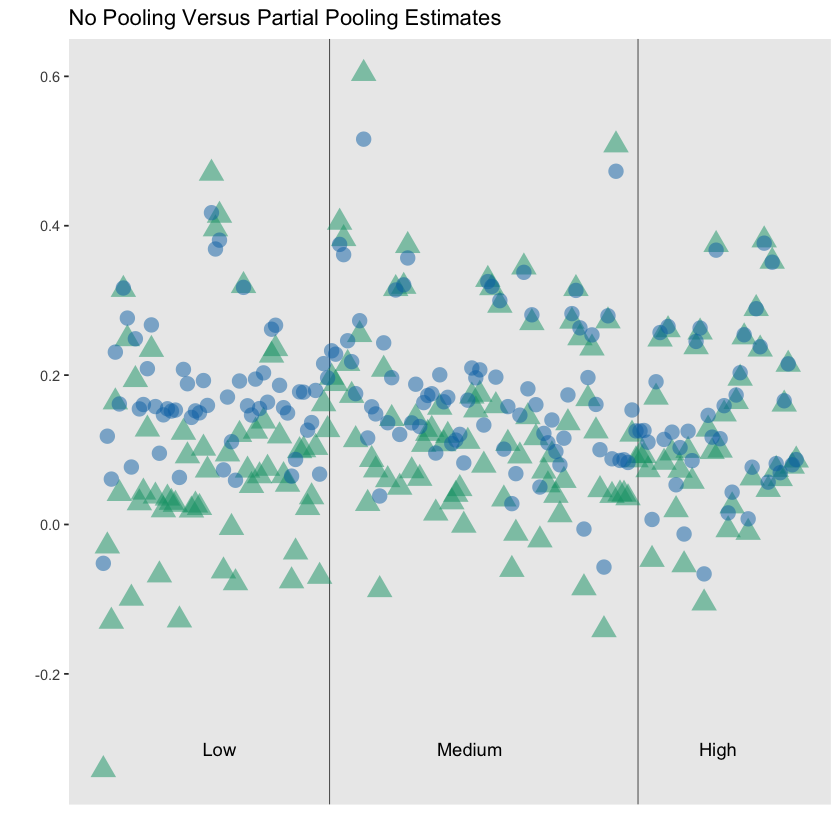

In [33]:
p3 <- post_mdn %>%
  ggplot(aes(x = order)) +
  geom_vline(xintercept = c(57.5, 134.5), linewidth = 1/4, color = "grey25") +
  geom_point(aes(y = est), shape = 17, color = "#009E73", alpha = .5, size = 5)+ #color = "orange", size = 2, alpha = .7
  geom_point(aes(y = Estimate), shape = 16, color = "#0072B2", alpha = .5, size = 4) + #size = 1, 
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  annotate(geom = "text", 
           x = c(30, 57.5 + 35, 134.5 + 20), y = -.3, 
           label = c("Low", "Medium", "High")) + 
xlab("")+
ylab("")+
ggtitle('No Pooling Versus Partial Pooling Estimates')
p3

ggsave("20250319_PhD_np2pp.jpg")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Saving 7 x 7 in image


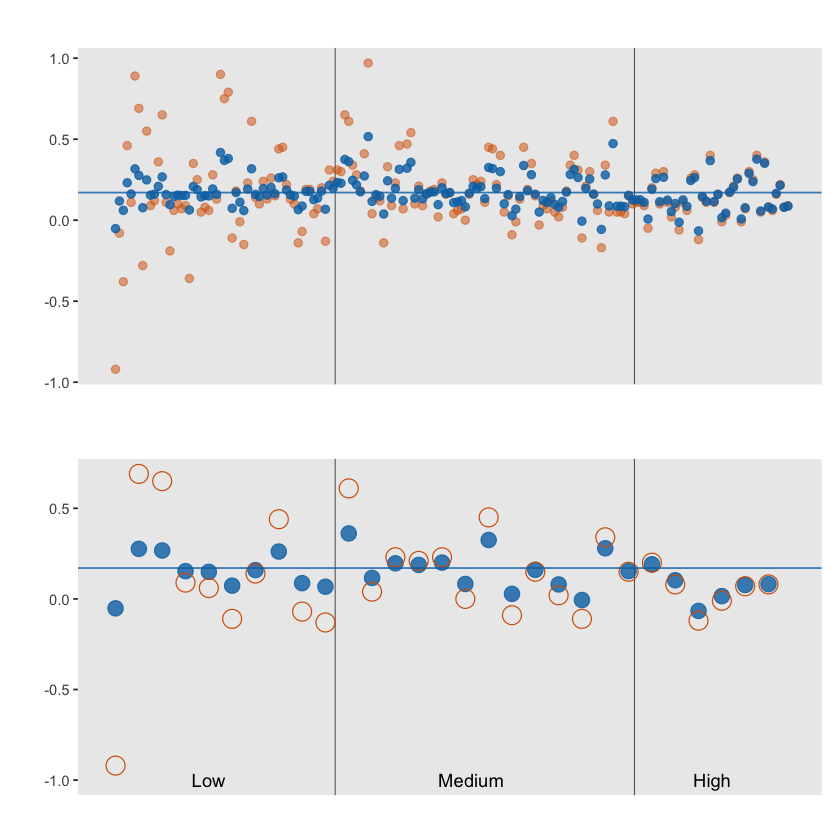

In [34]:
p1 <- post_mdn %>%
  ggplot(aes(x = order)) +
  geom_vline(xintercept = c(57.5, 134.5), linewidth = 1/4, color = "grey25") +
 geom_point(aes(y = mean), color = "#D55E00", alpha = .5, size = 2)+ #color = "yellow", size = 3, alpha = .5
 geom_point(aes(y = Estimate), color = "#0072B2", alpha = .8, size = 2) + #size = 1, 
 geom_hline(yintercept = mean(post$b_Intercept), linetype = 1, size = 1/2, colour = "#0072B2", alpha = .8)  +
 theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  #annotate(geom = "text", 
           #x = c(25, 57.5 + 35, 134.5 + 20), y = -1, 
           #label = c("Low", "Medium", "High")) + 
xlab("")+
ylab("")+
ggtitle('')+
coord_cartesian(xlim = c(0, 174))

# Take a sample to improve visibility
subset <- post_mdn[seq(1, nrow(post_mdn), 6), ]
#post_mdn

p2 <- subset %>%
  ggplot(aes(x = order)) +
  geom_vline(xintercept = c(57.5, 134.5), linewidth = 1/4, color = "grey25") +
  geom_point(aes(y = Estimate), color = "#0072B2", alpha = .8, size = 4) + #size = 1, 
  geom_point(aes(y = mean), shape = 1, color = "#D55E00", alpha = 1, size = 5)+ #color = "yellow", size = 3, alpha = .5
  geom_hline(yintercept = mean(post$b_Intercept), linetype = 1, size = 1/2, colour = "#0072B2", alpha = .8)  +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank(), panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
  annotate(geom = "text", 
           x = c(25, 57.5 + 35, 134.5 + 20), y = -1, 
           label = c("Low", "Medium", "High")) + 
xlab("")+
ylab("")+
ggtitle('')+
coord_cartesian(xlim = c(0, 174))

p1 / p2

ggsave("20250319_PhD_ppShrink.jpg")

#### Model Comparison

In [17]:
# Compare Models
f2cp_i <- add_criterion(f2cp, "waic")
f4npI_i <- add_criterion(f4npI, "waic")
f5pp_i <- add_criterion(f5pp, "waic")

w <- loo_compare(f2cp_i, f4npI_i, f5pp_i, criterion = "waic")

print(w, simplify = F)

        elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic  
f5pp_i     0.0       0.0  -324.6      68.6        117.9    8.3     649.2
f4npI_i  -15.1       5.8  -339.7      68.7        140.9    9.8     679.3
f2cp_i  -115.6      28.7  -440.1      55.6          3.4    0.2     880.3
        se_waic
f5pp_i   137.1 
f4npI_i  137.5 
f2cp_i   111.2 


In [20]:
wDF <- w %>% 
as.data.frame() %>% 
mutate(model = c("partial pooling", "no pooling (indexed)", "complete pooling")) %>% 
remove_rownames() %>%
column_to_rownames("model")%>%
select(waic, elpd_diff, se_diff)%>%
rename("WAIC" = 1, "Elapsed Difference" = 2, "Standard Error" = 3)%>%
mutate(across(1:3, round, 2))

wDF
#print(round(wDF, 2))

,WAIC,Elapsed Difference,Standard Error
,<dbl>,<dbl>,<dbl>
partial pooling,649.16,0.00,0.00
no pooling (indexed),679.33,-15.08,5.83
complete pooling,880.27,-115.55,28.72


In [39]:
glimpse(df)

Rows: 2,392
Columns: 42
$ docID.AT         <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ docid            <fct> 20910, 21062, 21062, 21324, 21334, 21334, 21354, 2135…
$ docyear          <int> 1891, 1871, 1871, 1892, 1891, 1891, 1890, 1890, 1800,…
$ docmonth         <int> 7, 11, 11, 5, 10, 10, 2, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1…
$ authorName       <fct> Isabella Weir Moore, E. Rothwell, E. Rothwell, Isabel…
$ docauthorid      <fct> IED0107, IED0179, IED0179, IED0107, IED0621, IED0621,…
$ authorLocation   <fct> USA, Canada, Canada, USA, USA, USA, USA, USA, USA, US…
$ authorGender     <fct> F, F, F, F, F, F, M, M, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> Irish, Irish, Irish, Irish, Irish, Irish, Irish, Iris…
$ irish            <fct> True, True, True, True, True, True, True, True, True,…
$ otherUK          <fct> False, False, False, False, False, False, False, Fals…
$ relMin           <fct> NA, NA, NA, NA, False, False, NA, NA, NA, NA, NA, NA,…
$ catholic      